# Compression Test

Compression evaluation based on the Hertzian Model

In [1]:
from isaacsim import SimulationApp
simulation_app = SimulationApp({"headless": False})
# simulation_app = SimulationApp({"headless": False, "launch_config": {"start_paused": True}})


import numpy as np
import matplotlib.pyplot as plt
import csv
import torch

from isaacsim.core.api import World
from isaacsim.core.api.objects import DynamicSphere
from isaacsim.core.api.materials.deformable_material import DeformableMaterial
from isaacsim.core.prims import SingleDeformablePrim
from isaacsim.core.utils import deformable_mesh_utils
from isaacsim.sensors.physics import ContactSensor
from omni.physx.scripts import physicsUtils
from pxr import UsdGeom, UsdPhysics
from isaacsim.core.prims import DeformablePrim

import isaacsim.core.utils.deformable_mesh_utils as deformableMeshUtils



Starting kit application with the following args:  ['/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/exts/isaacsim.simulation_app/isaacsim/simulation_app/simulation_app.py', '/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/apps/isaacsim.exp.base.python.kit', '--/app/tokens/exe-path=/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/kit', '--/persistent/app/viewport/displayOptions=3094', '--/rtx/materialDb/syncLoads=True', '--/rtx/hydra/materialSyncLoads=True', '--/omni.kit.plugin/syncUsdLoads=True', '--/app/renderer/resolution/width=1280', '--/app/renderer/resolution/height=720', '--/app/window/width=1440', '--/app/window/height=900', '--/renderer/multiGpu/enabled=True', '--/app/fastShutdown=False', '--/app/installSignalHandlers=0', '--ext-folder', '/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/exts', '--ext-folder', '/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/apps', '

2025-12-10T05:49:25Z [3,663ms] [Error] [asyncio] Exception in callback _patch_task.<locals>.step()
handle: <Handle _patch_task.<locals>.step()>
Traceback (most recent call last):
  File "/home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/kit/python/lib/python3.11/asyncio/events.py", line 84, in _run
    self._context.run(self._callback, *self._args)
RuntimeError: cannot enter context: <_contextvars.Context object at 0x718834506f80> is already entered
2025-12-10T05:49:25Z [4,025ms] [Error] [asyncio] Task was destroyed but it is pending!
task: <Task pending name='Task-34' coro=<_async_in_context.<locals>.run_in_context() done, defined at /home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/kit/python/lib/python3.11/site-packages/ipykernel/utils.py:57> wait_for=<Task pending name='Task-38' coro=<Kernel.shell_main() running at /home/rjrosales/Simulation/Custom_IsaacSim/_build/linux-x86_64/release/kit/python/lib/python3.11/site-packages/ipykernel/kernel

🟦 Single deformable block created at bottom z = 0.0
🟡 Indenter sphere at Z = 55.0 mm (10 mm above cube)
🔧 Prismatic joint created (no PhysX API layer)

📏 Deformable Block Z Bounds
  min Z = 0.018504 m
  max Z = 0.050892 m
  height = 0.032388 m

tensor(0.0550, device='cuda:0')
⏵ Ready — Press PLAY to start indentation
[5.681s] Simulation App Startup Complete
2025-12-10T05:49:44Z [23,171ms] [Warning] [isaacsim.core.simulation_manager.impl.simulation_manager] Disabling CCD for GPU dynamics as its not supported
[23.190s] [ext: omni.physx.fabric-107.3.26] startup
2025-12-10T05:49:46Z [24,579ms] [Warning] [isaacsim.core.prims.impl.deformable_prim] Please note that support for deformable prims in the current form is now deprecated. Some features including stress/strain APIs may be removed in the future.
2025-12-10T05:49:48Z [27,252ms] [Warning] [isaacsim.core.api.materials.deformable_material] A material prim already defined at path: /World/DeformableMaterial.
2025-12-10T05:49:48Z [27,257ms] 

2025-12-10T05:50:42Z [80,771ms] [Error] [omni.physx.tensors.plugin] Simulation view object is invalidated and cannot be used again to call getTransforms


### Simulation parameters

In [3]:
### USER CONSTANTS ###
BLOCK_SIZE     = 0.04        # 40 mm silicone cube edge
SPHERE_RADIUS  = 0.005       # 5 mm radius = 10 mm indenter diameter
DT             = 1/60    # use 240 Hz for deformables (recommended)

CSV_TAG   = "silicone10mmSphere_6mmComp"
CSV_FILE  = f"{CSV_TAG}_results.csv"
PLOT_FILE = f"{CSV_TAG}_plot.png"

### GUI Panel

In [4]:
def create_world():
    world = World(stage_units_in_meters=1.0, backend="torch", device="cuda")
    world.scene.add_default_ground_plane()
    return world, world.stage


def create_deformable_block(world, block_size=0.04, z_bottom=0.0):
    mesh_path = "/DeformableBlock"

    # 1) Make cube mesh (unit cube, triangulated)
    tri_points, tri_indices = deformableMeshUtils.createTriangleMeshCube(8)
    tri_points = np.array(tri_points) * block_size  # scale to e.g. 0.04 m

    mesh = UsdGeom.Mesh.Define(world.stage, mesh_path)
    mesh.GetPointsAttr().Set(tri_points.tolist())
    mesh.GetFaceVertexIndicesAttr().Set(tri_indices)
    mesh.GetFaceVertexCountsAttr().Set([3] * (len(tri_indices) // 3))

    # 2) Place bottom at z_bottom
    # The cube now spans [-block_size/2, +block_size/2] in local coords
    # So bottom is at -block_size/2 → we need +block_size/2 + z_bottom
    physicsUtils.setup_transform_as_scale_orient_translate(mesh)
    physicsUtils.set_or_add_translate_op(mesh, (0.0, 0.0, z_bottom + block_size/2))

    # 3) Material
    deform_mat = DeformableMaterial(
        prim_path="/World/DeformableMaterial",
        youngs_modulus=5e4,
        poissons_ratio=0.49,
        damping_scale=0.05,
        elasticity_damping=0.05,
        dynamic_friction=0.5,
    )

    # 4) Register SingleDeformablePrim
    deformable = SingleDeformablePrim(
        prim_path=mesh_path,
        name="silicone_block",
        deformable_material=deform_mat,
        simulation_hexahedral_resolution=3,
        solver_position_iteration_count=40,
        self_collision=True,
        collision_simplification=True,
    )

    world.scene.add(deformable)
    print("🟦 Single deformable block created at bottom z =", z_bottom)
    return deformable




def create_dynamic_sphere(world):
    block_top = BLOCK_SIZE                  # 0.04 m
    gap = 0.01                              # 1 mm
    start_z = block_top + SPHERE_RADIUS + gap  # 0.04 + 0.005 + 0.001 = 0.046 m

    sphere = world.scene.add(
        DynamicSphere(
            prim_path="/Sphere",
            name="indenter",
            radius=SPHERE_RADIUS,  # 0.005 m
            position=np.array([0, 0, start_z]),
            mass=0.01,             # 10 g
            color=np.array([255,255,0])
        )
    )

    print(f"🟡 Indenter sphere at Z = {start_z*1000:.1f} mm "
          f"({gap*1000:.0f} mm above cube)")
    return sphere


## Sensor and Prismatic Joint

In [5]:
def attach_contact_sensor(world):
    sensor = world.scene.add(
        ContactSensor(
            prim_path="/Sphere/sensor",
            name="sphere_sensor",
            radius=0.05,
            min_threshold=0.0,
            max_threshold=1e6,
        )
    )
    sensor.add_raw_contact_data_to_frame()
    return sensor


def create_prismatic_joint(stage):
    joint = UsdPhysics.PrismaticJoint.Define(stage, "/World/JointZ")
    joint.CreateAxisAttr("Z")

    # ----------------------------------------
    # 6 mm indentation limits (27 mm -> 21 mm)
    # ----------------------------------------
    joint.CreateUpperLimitAttr(0.055)   # starting height (2 mm above)
    joint.CreateLowerLimitAttr(0.041)   # 6 mm indentation


    # static reference body
    xform = UsdGeom.Xform.Define(stage, "/World/Ref")
    joint.CreateBody0Rel().SetTargets(["/World/Ref"])

    # joint drives the sphere
    joint.CreateBody1Rel().SetTargets(["/Sphere"])

    # drive setup
    drive = UsdPhysics.DriveAPI.Apply(joint.GetPrim(), "linear")
    drive.CreateTypeAttr().Set("position")
    drive.CreateStiffnessAttr().Set(2e5)
    drive.CreateDampingAttr().Set(1e4)

    print("🔧 Prismatic joint created (no PhysX API layer)")

    # ⛔️ RETURN *ONLY* THIS
    return drive



### Simulation Loop

In [6]:
def run_test(world, drive, sensor, sphere):
    time_log, disp_log, force_log = [], [], []
    sim_time = 0.0

    target = 0.055   # sphere center 2 mm above the cube
    direction = -1

    # 🔑 FIX: command start height before running sim
    drive.GetTargetPositionAttr().Set(target)

    print("⏵ Ready — Press PLAY to start indentation")

    while simulation_app.is_running():

        if world.is_playing():

            sim_time += DT
            time_log.append(sim_time)

            # Move the indenter 6 mm down and back
            target += 0.0001 * direction   # slow, precise indentation

            if target <= 0.041: direction = +1   # reached 6 mm compression
            elif target >= 0.055: direction = -1

            drive.GetTargetPositionAttr().Set(target)

            # Actual sphere position
            disp_log.append(sphere.get_world_pose()[0][2])

            # Contact force from sensor
            frame = sensor.get_current_frame()
            fn = float(frame["force"][2]) if frame["in_contact"] else 0.0
            force_log.append(abs(fn))

        # STOP ends test and returns data
        if world.is_stopped() and len(time_log) > 10:
            print("⏹ STOP detected → Test finished")
            return time_log, disp_log, force_log

        world.step(render=True)



### Data Logging

In [7]:
def save_csv(time, disp, force):
    with open(CSV_FILE, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["time_s", "sphere_z_m", "normal_force_N"])
        for t, z, fn in zip(time, disp, force):
            w.writerow([t, z, fn])
    print("🧾 CSV saved →", CSV_FILE)

def save_plot(time, disp, force):

    def to_np(x):
        if isinstance(x, torch.Tensor):
            return x.detach().cpu().numpy()
        if isinstance(x, (list, tuple)):
            return np.array([to_np(v) for v in x])
        return np.array(x)

    time  = to_np(time)
    disp  = to_np(disp)
    force = to_np(force)

    plt.figure(figsize=(7,4))
    plt.plot(disp, force, linewidth=2)
    plt.xlabel("Sphere Displacement (m)")
    plt.ylabel("Normal Force (N)")
    plt.title("Sphere Compression — Force vs Displacement")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(PLOT_FILE, dpi=300)
    plt.show()

    print("📈 Plot saved →", PLOT_FILE)

### World and Scene Setup

In [9]:

world, stage = create_world()
block = create_deformable_block(world)
sphere = create_dynamic_sphere(world)
sensor = attach_contact_sensor(world)
drive = create_prismatic_joint(stage)
world.reset()

Exception: Cannot add the object silicone_block to the scene since its name is not unique

In [10]:
def print_block_bounds(world):
    dp = DeformablePrim(prim_paths_expr="/DeformableBlock")
    world.scene.add(dp)
    dp.initialize()

    pts = dp.get_simulation_mesh_nodal_positions()  # torch tensor
    z = pts[:, :, 2].cpu().numpy()                  # move to CPU

    print("\n📏 Deformable Block Z Bounds")
    print(f"  min Z = {z.min():.6f} m")
    print(f"  max Z = {z.max():.6f} m")
    print(f"  height = {z.max() - z.min():.6f} m\n")
print_block_bounds(world)
frame = sensor.get_current_frame()
frame.keys()
print(sphere.get_world_pose()[0][2])



In [11]:
# world.reset(soft=False)
time, disp, force = run_test(world, drive, sensor, sphere)


Exception: Failed to get rigid body transforms from backend

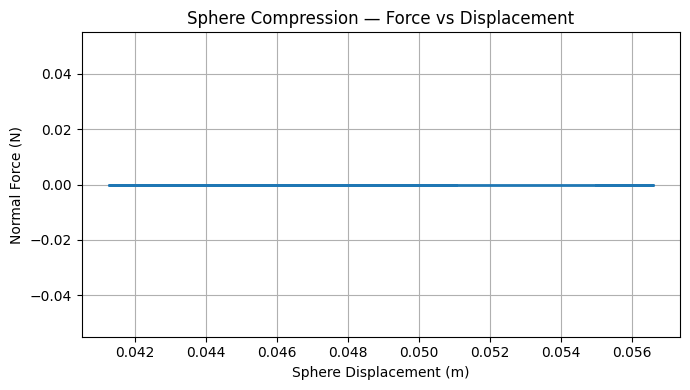

In [10]:
# save_csv(time, disp, force)
save_plot(time, disp, force)

In [ ]:
simulation_app.close()